In [2]:
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings(action='ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
origin_df = pd.read_csv("특별자치구.csv", parse_dates=['YMD_CD'], index_col=0)

In [5]:
origin_df.shape

(3388672, 22)

In [6]:
sale_sum = origin_df.groupby('ITEM_CD').agg({"SALE_QTY":"sum"})
zero_items = list(sale_sum[sale_sum['SALE_QTY']==0].index)

In [7]:
zero_items

[18200004735,
 28400017244,
 796030214967,
 796030814921,
 2201148598758,
 2201148622224,
 2201148630595,
 2201148639369,
 2201148642017,
 2201148642031,
 2201148642048,
 2202000080114,
 2202000080121,
 4105120004108,
 4105120673823,
 4105120673878,
 4770301234010,
 4901626055046,
 5010035000697,
 5010035000710,
 6970729560052,
 6970729569437,
 8002590042745,
 8413681305388,
 8594403110128,
 8800246200002,
 8801001237004,
 8801019312069,
 8801019312588,
 8801019316210,
 8801019316364,
 8801019318450,
 8801019318528,
 8801019603440,
 8801019605505,
 8801019611056,
 8801019612435,
 8801019612565,
 8801019612589,
 8801021105345,
 8801021105598,
 8801021233604,
 8801021233925,
 8801022023082,
 8801022023181,
 8801037013702,
 8801037097122,
 8801043026321,
 8801043026505,
 8801045003054,
 8801045865386,
 8801056236236,
 8801056238599,
 8801056242398,
 8801056242404,
 8801056242718,
 8801056244170,
 8801062003389,
 8801062004119,
 8801062004942,
 8801062005918,
 8801062006267,
 8801062006519

In [8]:
origin_df = origin_df[~origin_df['ITEM_CD'].isin(zero_items)]

In [9]:
item_mst1 = pd.read_csv('ITEM_MST.txt', encoding='cp949', sep='|')
item_mst2 = pd.read_csv('ITEM_MST2.txt', encoding='cp949', sep='|')
item_mst = pd.concat([item_mst1, item_mst2], ignore_index=True)

In [10]:
item_mst

,ITEM_CD,ITEM_NM,DETA_CD,DETA_NM,SMCL_CD,SMCL_NM,HYUN_MAEGA,ITEM_SPEC,ITEM_SW,ITEM_SL,ITEM_SH,CHULGO_DAY,ORD_START_YMD
0,8801037039993,티오피)스위트아메캔200ml,1122,캔커피,122,캔/병커피,1200,200,50,50,115,237,20101125
1,8801117276201,오리온)촉촉한초코칩,4038,초코(비스킷),38,비스켓,2400,132,200,80,65,243,20120922
2,8801858011024,카스캔500ml,2134,캔(국산맥주),134,국산맥주,2800,500,70,70,170,243,20010307
3,8801094082604,코카)코카콜라제로P500ml,3125,콜라,125,일반탄산음료,2300,500,65,65,220,237,20070430
4,8801062516858,롯데)칸쵸컵,4038,초코(비스킷),38,비스켓,2700,88,90,90,111,200,20221019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,8801094083625,코카)제로올림픽490ml캔,3125,콜라,125,일반탄산음료,2200,490,66,66,168,475,20240626
864,8801094013615,코카)레드올림픽490ml캔,3125,콜라,125,일반탄산음료,2200,490,132,66,168,475,20240626
865,8801121044698,매일)허쉬초코딸기190ml,2130,딸기우유,130,가공유,1400,190,47,37,120,46,20240626
866,8801043036436,농심)포스틱84g,1043,NaN,42,일반스낵,1700,84,200,55,260,100,20160820


In [11]:
origin_df

,YMD_CD,SMCL_CD,PRST_NO,ITEM_CD,SALE_QTY,day_0,day_1,day_2,day_3,day_4,day_5,day_6,WEEKDAY,FRIDAY,HOLIDAY,SALE_QTY_lag1,SALE_QTY_lag2,SALE_QTY_lag3,SALE_QTY_lag4,SALE_QTY_lag5,SALE_QTY_lag6,SALE_QTY_lag7
800,2022-12-04,38,34984,76224935,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
801,2022-12-04,38,34984,80001249,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,2022-12-04,38,34984,80001263,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,2022-12-04,38,34984,80176732,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,2022-12-04,38,34984,80906032,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60995997,2024-04-04,135,221915,9015180127820,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60995998,2024-04-04,135,221915,9028800137468,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60996001,2024-04-04,135,221915,9329982020877,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60996002,2024-04-04,135,221915,9414453903794,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
temp_subset = item_mst[['ITEM_CD', 'ITEM_NM']]

In [13]:
origin_df = origin_df.merge(temp_subset, on='ITEM_CD', how='left')

In [14]:
origin_df

,YMD_CD,SMCL_CD,PRST_NO,ITEM_CD,SALE_QTY,day_0,day_1,day_2,day_3,day_4,day_5,day_6,WEEKDAY,FRIDAY,HOLIDAY,SALE_QTY_lag1,SALE_QTY_lag2,SALE_QTY_lag3,SALE_QTY_lag4,SALE_QTY_lag5,SALE_QTY_lag6,SALE_QTY_lag7,ITEM_NM
0,2022-12-04,38,34984,76224935,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,앰지)밀카초코슈프림30g
1,2022-12-04,38,34984,80001249,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,델리팜)로아카바닐라45g
2,2022-12-04,38,34984,80001263,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,델리팜)로아카카카오45g
3,2022-12-04,38,34984,80176732,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,매일)킨더해피히포21g
4,2022-12-04,38,34984,80906032,0,0,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,매일)킨더트롱키18g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678139,2024-04-04,135,221915,9015180127820,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,예거복숭아캔500ml
2678140,2024-04-04,135,221915,9028800137468,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,에델바이스피치캔500ml
2678141,2024-04-04,135,221915,9329982020877,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,신)크루저블루베리병275ml
2678142,2024-04-04,135,221915,9414453903794,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KGB레몬병330ml


In [15]:
def plot_arima(origin_df:pd.DataFrame, prst_no:int, item_cd:int):
    filtered_df = origin_df[(origin_df['PRST_NO']==prst_no)&(origin_df['ITEM_CD']==item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year==2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year==2024]
    filtered_train.set_index('YMD_CD', inplace=True)
    filtered_test.set_index('YMD_CD', inplace=True)
    if not isinstance(filtered_train.index, pd.DatetimeIndex):
        filtered_train.index = pd.to_datetime(filtered_train.index)
    if not isinstance(filtered_test.index, pd.DatetimeIndex):
        filtered_test.index = pd.to_datetime(filtered_test.index)

    # ARIMA 모델 설정 및 학습
    model = ARIMA(filtered_train['SALE_QTY'], order=(1, 1, 1))
    model_fit = model.fit()

    # 예측 설정
    forecast_steps = len(filtered_test)
    forecast_index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='D')
    forecast = model_fit.forecast(steps=forecast_steps)
    

    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train['SALE_QTY'], label='Train Sales')
    plt.plot(filtered_test['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.title('Sales Forecast for Jan-Mar 2024 using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    
    # 경로가 존재하지 않으면 생성
    output_dir = "fig/arima"
    os.makedirs(output_dir, exist_ok=True)

    # 그래프 저장
    plt.savefig(f"{output_dir}/ARIMA_PRST_NO({prst_no})_ITEM_CD({item_cd}).png")
    plt.show()

In [16]:
def plot_prophet(origin_df: pd.DataFrame, prst_no: int, item_cd: int):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    
    filtered_train.set_index('YMD_CD', inplace=True)
    filtered_test.set_index('YMD_CD', inplace=True)
    
    if not isinstance(filtered_train.index, pd.DatetimeIndex):
        filtered_train.index = pd.to_datetime(filtered_train.index)
    if not isinstance(filtered_test.index, pd.DatetimeIndex):
        filtered_test.index = pd.to_datetime(filtered_test.index)
    
    train_prophet = filtered_train.reset_index().rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'})
    
    model = Prophet()
    
    features = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'WEEKDAY', 
                'FRIDAY', 'HOLIDAY', 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 
                'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7']
    
    for feature in features:
        model.add_regressor(feature)
    
    model.fit(train_prophet)
    
    # 예측 설정
    future_dates = model.make_future_dataframe(periods=len(filtered_test), freq='D')
    
    # 미래 데이터프레임에 추가 특성들 포함
    future_with_features = future_dates.merge(filtered_df[['YMD_CD'] + features], left_on='ds', right_on='YMD_CD', how='left')
    
    forecast = model.predict(future_with_features)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train.index, filtered_train['SALE_QTY'], label='Train Sales')
    plt.plot(filtered_test.index, filtered_test['SALE_QTY'], label='Test Sales')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    plt.title('Sales Forecast for Jan-Mar 2024 using Prophet')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()

In [17]:
# SARIMA 모델 플로팅 함수 정의
def plot_sarima(origin_df: pd.DataFrame, prst_no: int, item_cd: int):
    filtered_df = origin_df[(origin_df['PRST_NO'] == prst_no) & (origin_df['ITEM_CD'] == item_cd)]
    filtered_train = filtered_df[filtered_df['YMD_CD'].dt.year == 2023]
    filtered_test = filtered_df[filtered_df['YMD_CD'].dt.year == 2024]
    filtered_train.set_index('YMD_CD', inplace=True)
    filtered_test.set_index('YMD_CD', inplace=True)

    if not isinstance(filtered_train.index, pd.DatetimeIndex):
        filtered_train.index = pd.to_datetime(filtered_train.index)
    if not isinstance(filtered_test.index, pd.DatetimeIndex):
        filtered_test.index = pd.to_datetime(filtered_test.index)

    # SARIMA 모델 설정 및 학습
    model = SARIMAX(filtered_train['SALE_QTY'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    # 예측 설정
    forecast_steps = len(filtered_test)
    forecast_index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='D')
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_train['SALE_QTY'], label='Train Sales')
    plt.plot(filtered_test['SALE_QTY'], label='Test Sales')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.title('Sales Forecast for Jan-Mar 2024 using SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    
    # 경로가 존재하지 않으면 생성
    output_dir = "fig/sarima"
    os.makedirs(output_dir, exist_ok=True)

    # 그래프 저장
    plt.savefig(f"{output_dir}/SARIMA_PRST_NO({prst_no})_ITEM_CD({item_cd}).png")
    plt.show()

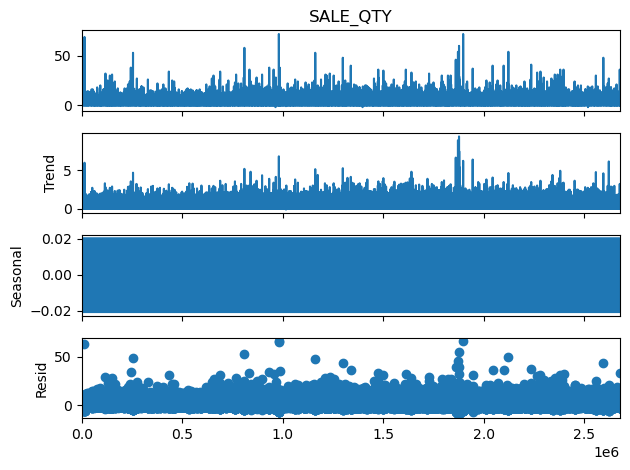

In [42]:
# 시계열 분해로 계절성 찾기
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(origin_df['SALE_QTY'], model='additive', period=12)
result.plot()
plt.show()

In [43]:
#acf, pacf로 계절성 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 및 PACF 플롯
plot_acf(origin_df['SALE_QTY'])
plot_pacf(origin_df['SALE_QTY'])
plt.show()

In [39]:
# 최적의 파라미터 찾기 위한 함수 정의
def find_best_sarima_params(data, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(ParameterGrid({'p': p, 'd': d, 'q': q}))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in pdq]
    
    best_aic = float("inf")
    best_params = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(data,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, param_seasonal)
            except Exception as e:
                continue
    return best_params

In [17]:
store_ids = origin_df['PRST_NO'].unique()
item_cds = origin_df['ITEM_CD'].unique()
item_nms = origin_df['ITEM_NM'].unique()

In [ ]:
for prst_no in store_ids:
    for item_cd in item_cds:
        item_nm = origin_df[origin_df['ITEM_CD'] == item_cd]['ITEM_NM'].values[0]
        plot_arima(origin_df, prst_no=prst_no, item_cd=item_cd)
        print('현재 플롯의 아이템:', item_cd, item_nm)

In [29]:
# PRST_NO별 ITEM_CD 기준으로 SALE_QTY를 합산
grouped_df = origin_df.groupby(['PRST_NO', 'ITEM_CD'])['SALE_QTY'].sum().reset_index()

# SALE_QTY 기준으로 내림차순 정렬 후 상위 10개 상품 선택
top_10_items = grouped_df.sort_values(by='SALE_QTY', ascending=False).head(10)

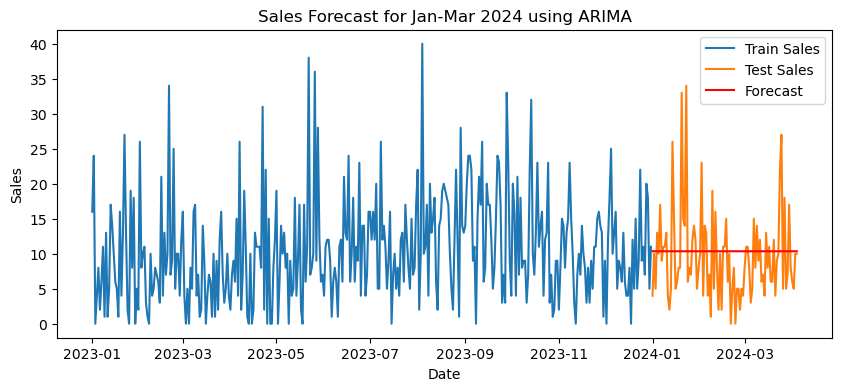

In [32]:
# 제주도에서 제일 잘팔리는 템 arima 테스트(카스)
plot_arima(origin_df, 221327, 8801858011024)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52895D+00    |proj g|=  6.05929D-02

At iterate    5    f=  3.38350D+00    |proj g|=  1.69458D-01


 This problem is unconstrained.



At iterate   10    f=  3.35124D+00    |proj g|=  1.94740D-03

At iterate   15    f=  3.35098D+00    |proj g|=  2.05796D-03

At iterate   20    f=  3.35066D+00    |proj g|=  1.13685D-03

At iterate   25    f=  3.35063D+00    |proj g|=  7.89063D-04

At iterate   30    f=  3.35062D+00    |proj g|=  2.41366D-04

At iterate   35    f=  3.35062D+00    |proj g|=  1.22683D-04

At iterate   40    f=  3.35062D+00    |proj g|=  1.82867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     44      1     0     0   2.166D-05   3.351D+00
  F =   3.3506154586213359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

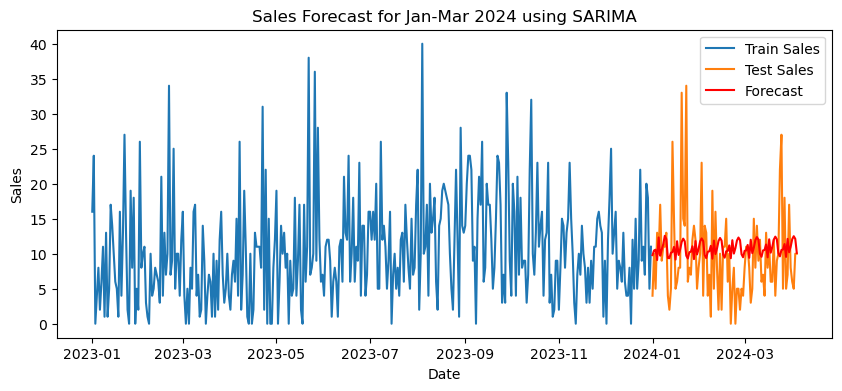

In [36]:
plot_sarima(origin_df, 221327, 8801858011024)

11:43:44 - cmdstanpy - INFO - Chain [1] start processing
11:43:45 - cmdstanpy - INFO - Chain [1] done processing


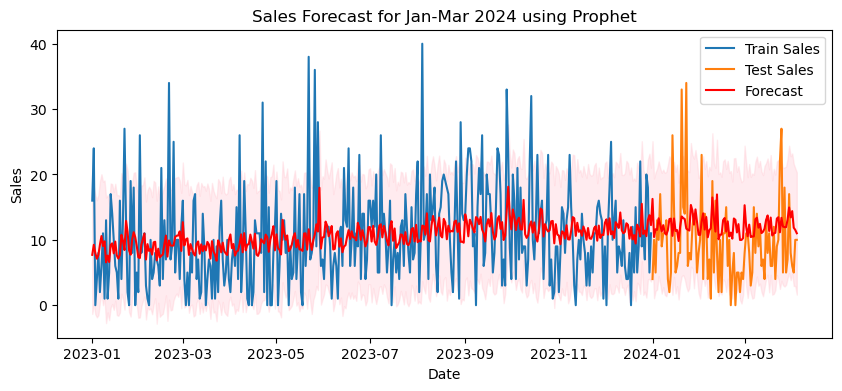

In [18]:
plot_prophet(origin_df, 221327, 8801858011024)

In [30]:
top_10_items

,PRST_NO,ITEM_CD,SALE_QTY
3966,221327,8801858011024,4926
536,34984,8801858011024,4006
1908,122612,8801858011024,3526
3437,221327,88002798,2781
2594,151539,8801858011024,2758
4809,221915,88002798,2694
1777,122612,8801115134237,2676
5338,221915,8801858011024,2649
7,34984,88002798,2495
1379,122612,88002798,2465


In [ ]:
for prst_no in store_ids:
    for item_cd in item_cds:
        plot_prophet(origin_df, prst_no=prst_no, item_cd=item_cd)
        print('현재 플롯의 아이템 :', item_cd, item_nm)

## Prophet

11:47:50 - cmdstanpy - INFO - Chain [1] start processing
11:47:50 - cmdstanpy - INFO - Chain [1] done processing


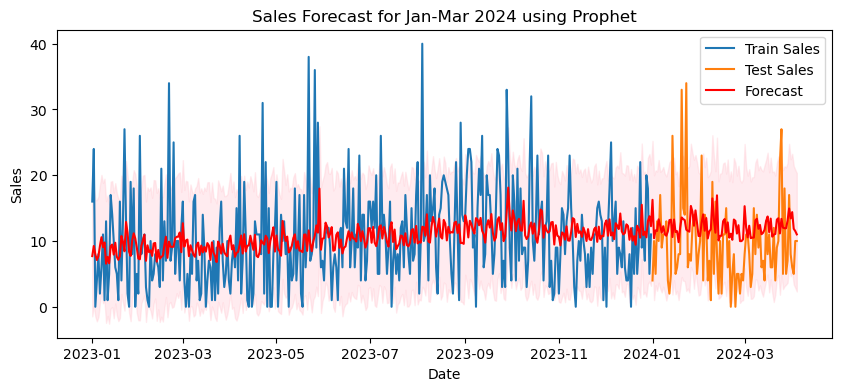

In [18]:
plot_prophet(origin_df, 221327, 8801858011024)

In [23]:
filtered_df = origin_df[(origin_df['PRST_NO'] == 221327) & (origin_df['ITEM_CD'] == 8801858011024)][['SALE_QTY', 'YMD_CD']]

In [24]:
filtered_df

,SALE_QTY,YMD_CD
4676,9,2022-12-04
10164,8,2022-12-05
15652,5,2022-12-06
21140,4,2022-12-07
26628,2,2022-12-08
...,...,...
2655380,8,2024-03-31
2660868,6,2024-04-01
2666356,5,2024-04-02
2671844,10,2024-04-03


In [26]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 488 entries, 4676 to 2677332
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SALE_QTY  488 non-null    int64         
 1   YMD_CD    488 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.4 KB


In [27]:
filtered_df.rename(columns={'YMD_CD': 'ds', 'SALE_QTY': 'y'}, inplace=True)

In [28]:
m = Prophet()
m.fit(filtered_df)

11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

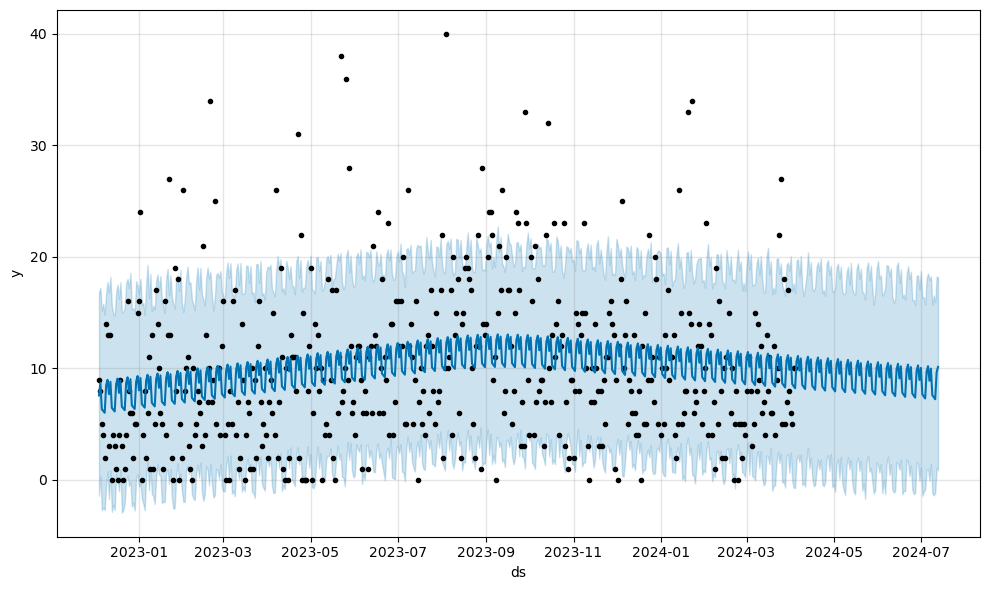

In [30]:
fig1 = m.plot(forecast)

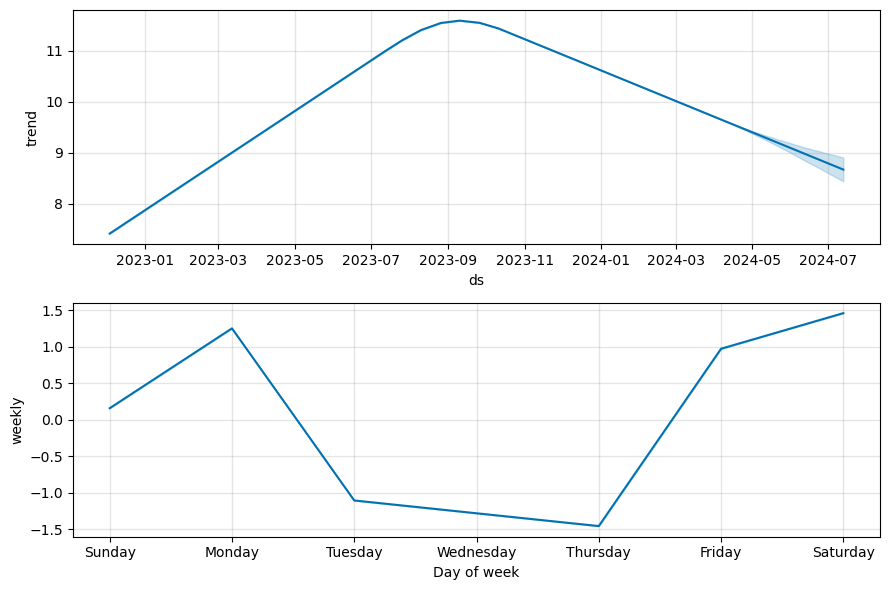

In [31]:
fig2 = m.plot_components(forecast)

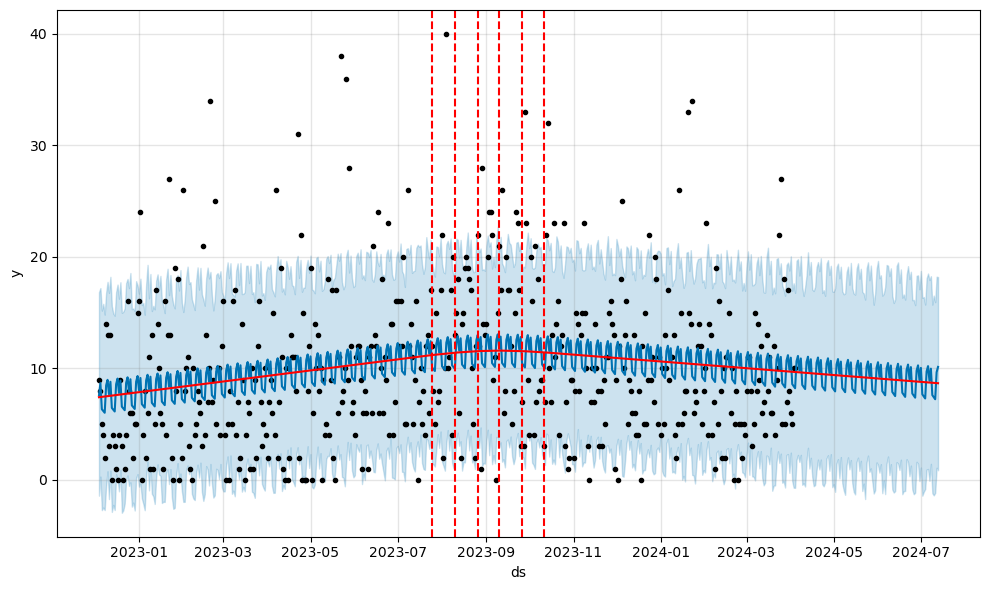

In [33]:
# changepoint_prior_scale 0.5가 디폴트 옵션 너무 높여주면 오버피팅의 위험이 있음(0.3으로 줄이는게 트랜드 유연성을 높이는 것)
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [34]:
filtered_df

,y,ds
4676,9,2022-12-04
10164,8,2022-12-05
15652,5,2022-12-06
21140,4,2022-12-07
26628,2,2022-12-08
...,...,...
2655380,8,2024-03-31
2660868,6,2024-04-01
2666356,5,2024-04-02
2671844,10,2024-04-03


In [ ]:
# 만약 서비스 확대 배포, 프로모션 시점을 알고 있다면 changepoints 파라미터를 추가할 수 있음
# n_changepoints를 사용한다. 물론 자동 감지 함
# 푸리에급수를 이용해 계절성을 추정한다. 연계절, 주계절, 일계절성이 있고 계절정 반영 강도가 있음.

12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing


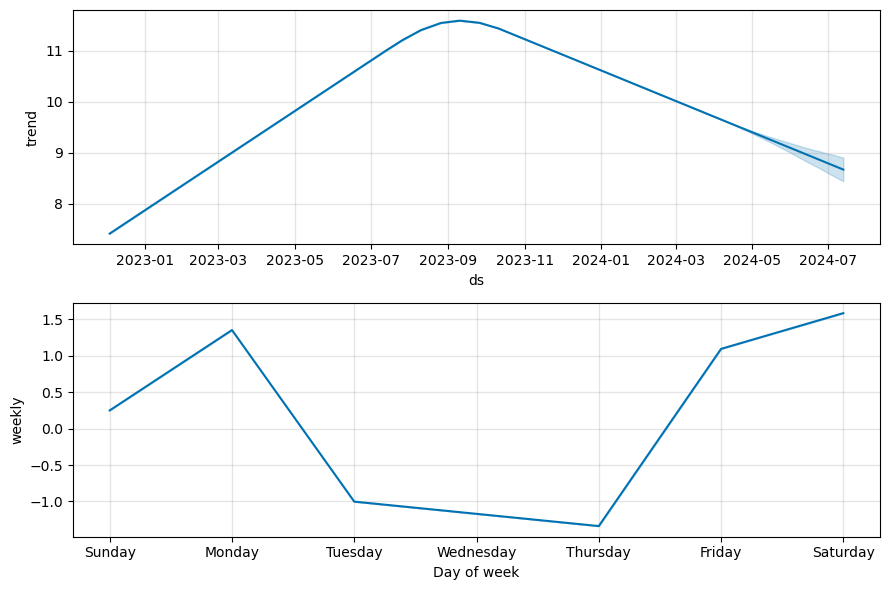

In [36]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=20,
    daily_seasonality=False
)

m.fit(filtered_df)
fig = m.plot_components(forecast)

In [ ]:
# 기본 제공 시즈널리티는 일, 주, 년이지만 월단위를 추가할 수도 있음
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [37]:
# 추가 파라메터 : additive - 진폭이 일정함. Multiplicative - 진폭이 점점 증가하거나 감소함

In [ ]:
# holiday : 휴일 또는 이벤트 기간을 명시한 데이터 프레임에서 가져올 수 있음. holiday_prior_scale에서 홀리데이 반영 강도를 지정할 수 있음.
# 공휴일 영향이 그 다음날에도 영향을 미친다면 lower_window = 0, upper window = 1를 추가해주면 됨

In [38]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [ ]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    # holiday
    holidays=holiday,
    holidays_prior_scale=15
)

# Specifying Custom Seasonalities
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(df)
forecast = m.predict(future)

fig = plot_plotly(m, forecast) 
py.iplot(fig)   